In [2]:
import numpy as np
import pandas as pd 
import os
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import find_peaks, hilbert, savgol_filter
from VMD import vmd
import mat73
from statistics import mode
import math

import datetime


from scipy.signal import butter, lfilter, find_peaks, filtfilt, sosfilt, hilbert, savgol_filter
from time import strftime
from numpy.lib.function_base import angle
from doppler_processing import doppler_processing,separate_tx
import compensation
from utils import ca_cfar_2d,blink_detection
# from libs.Capon2D import capon
import matplotlib.patches as pat



In [73]:
# input information
# filename = "0110_60cm_1"
experiment_time = 1
experiment_title = "Distance suiji - mingyang"
FPS = 30
blink_low = 60
blink_high = 100

# read radar data from .mat file
mat = mat73.loadmat(r"G:\data\ti\DCA_1000\output\0213_wang_breath_hold_2.mat")  # load mat-file
matnp = np.asarray( mat['radarCube']['data'])
print(matnp.shape)

# read ground truth for a group of experiment
gt = pd.read_csv(r"G:\data\ti\DCA_1000\datatime\0116_mingyang_60cm_2.csv", header=None)
# gt = pd.read_csv(f"/Volumes/BrahimWalid/BlinkData/{filename}.csv", header=None)
groundtruth = np.asarray(gt)
groundtruth = groundtruth[experiment_time-1]
print(groundtruth)

(314, 96, 4, 64)
[ 5.00036454  9.00153852 16.0029366  19.00423241 25.00428319 28.00584102
 35.00674462 39.00830579 44.0083611  49.00946426 56.01050997 63.01102734
 69.01141953 72.01274657 79.01310515]


### Data Processing

In [74]:
# Utility functions:
def clutter_remove(range_matrix):
    for range_idx in range(range_matrix.shape[1]):
        range_avg = np.mean(range_matrix[:, range_idx])
#         print(range_idx, range_avg)
        range_matrix[:, range_idx] = range_matrix[:, range_idx] - range_avg
    return range_matrix

def unwrap_phase_Ambiguity(phase_queue, points_num):
    # for range_idx in range(0, points_num):
    phase_arr = phase_queue #[:, range_idx]
    phase_arr_ret = phase_arr.copy()
    phase_diff_correction_cum = 0
    for i in range(len(phase_arr)):
        if not i:
            continue
        else:
            phase_diff = phase_arr[i] - phase_arr[i - 1]
            # print(len(phase_diff))
            if phase_diff > 180:
                mod_factor = 1
            elif phase_diff < -180:
                mod_factor = -1
            else:
                mod_factor = 0
        phase_diff_mod = phase_diff - mod_factor * 2 * 180
        if phase_diff_mod == -180 and phase_diff > 0:
            phase_diff_mod = 180
        phase_diff_correction = phase_diff_mod - phase_diff
        if (phase_diff_correction < 180 and phase_diff_correction > 0) \
                or (phase_diff_correction > -180 and phase_diff_correction < 0):
            phase_diff_correction = 0
        phase_diff_correction_cum += phase_diff_correction
        phase_arr_ret[i] = phase_arr[i] + phase_diff_correction_cum
    # phase_queue[:, range_idx] = phase_arr_ret
        phase_queue = phase_arr_ret
    return phase_queue

def hampel(X):
    length = X.shape[0] - 1
    k = 3
    nsigma = 3
    iLo = np.array([i - k for i in range(0, length + 1)])
    iHi = np.array([i + k for i in range(0, length + 1)])
    iLo[iLo < 0] = 0
    iHi[iHi > length] = length
    xmad = []
    xmedian = []
    for i in range(length + 1):
        w = X[iLo[i]:iHi[i] + 1]
        medj = np.median(w)
        mad = np.median(np.abs(w - medj))
        xmad.append(mad)
        xmedian.append(medj)
    xmad = np.array(xmad)
    xmedian = np.array(xmedian)
    scale = 1  # 缩放
    xsigma = scale * xmad
    xi = ~(np.abs(X - xmedian) <= nsigma * xsigma)  # Find outliers (ie more than nsigma standard deviations)

    # Replace outliers with median values
    xf = X.copy()
    xf[xi] = xmedian[xi]
    return xf

def phase_difference(data):
    data_0 = data[1:]
    data_1 = data[:-1]
    data = np.array(data_0) - np.array(data_1)
    data = hampel(data)
    return data

def fft_find_frequency(data, sampling_period = 30, start_idx=0, threshold=None):
    n = len(data)
    # FFT result corresponds to actual frequency
    frequency = np.arange(n / 2) * sampling_period / n
    fft_out = np.fft.fft(data)
    fft_am = abs(fft_out)
    fft_out_am = fft_am[start_idx:int(len(fft_am) / 2)]
    fft_max_index = np.argmax(fft_out_am) + start_idx
    fft_max = fft_out_am.max()
    max_fq = frequency[fft_max_index] if fft_max_index < len(frequency) else frequency[-1]
    return max_fq

def plotSpectrum(y,Fs=30):
    """
    Plots a Single-Sided Amplitude Spectrum of y(t)
    """
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    mag = abs(Y)
    return frq[np.argmax(mag)]

In [75]:
## take 1 chirp from each frame of one antenna
radar_1dfft_data = matnp[:,0,0,:]

In [76]:
## Clutter removal
decluttered_1dfft = clutter_remove(radar_1dfft_data)


In [77]:
# Extract magnitude and locate max power range bin:walid
magn_data = np.abs(decluttered_1dfft)
# print(magn_data)
bins = []

# Check if there is target:
for i in range(len(magn_data)):
    bins.append(np.argmax(magn_data[i,:]))
target_bin = mode(bins)-1
print(f'The target is located in range bin: {target_bin}')

The target is located in range bin: 8


In [79]:
# Plot range heatmap:
%matplotlib qt
plt.rcParams.update({'font.size': 35})
plt.rcParams["figure.figsize"] = (20,10)
# plt.imshow(magn_data/magn_data.max(), cmap='viridis', norm = matplotlib.colors.Normalize(), aspect='auto', extent=[0, 64*0.088, len(magn_data)*33.33/1000, 0])
plt.imshow(magn_data/magn_data.max(), cmap='viridis', norm = matplotlib.colors.Normalize(), aspect='auto', extent=[0, 64, len(magn_data)*33.33/1000, 0])
# plt.imshow(magn_data/magn_data.max(),cmap='turbo', norm = matplotlib.colors.Normalize(), aspect='auto', extent=[0, 64*0.088, len(magn_data)*33.33/1000, 0])
plt.colorbar()
plt.title('Range Profile Map')
plt.xlabel('Range (m)')
plt.ylabel('Time (sec)')
plt.show()

In [80]:
# Phase Signal & Unwrapping:
phase_data = np.angle(decluttered_1dfft[:,target_bin], deg=True)  # => displacement signal at selected range bin
# phase_data = np.angle(decluttered_1dfft[:,1], deg=True) 

unwrapped_data = unwrap_phase_Ambiguity(phase_data, 64)
print(unwrapped_data.shape)

(314,)


In [81]:
phase_data = np.angle(decluttered_1dfft[:,target_bin], deg=True)  # => displacement signal at selected range bin
phase_data_before1=np.angle(decluttered_1dfft[:,target_bin-1], deg=True)
phase_data_after1=np.angle(decluttered_1dfft[:,target_bin+1], deg=True)
# phase_sum=phase_data+phase_data_before1+phase_data_after1
unwrapped_data = unwrap_phase_Ambiguity(phase_data, 64)
time_arr = np.linspace(0, len(unwrapped_data)/FPS, len(unwrapped_data))
list_phase_data=[phase_data,phase_data_before1,phase_data_after1]#,phase_sum]
list_unwrapped_data=[]
for i in list_phase_data:
    list_unwrapped_data.append(unwrap_phase_Ambiguity(i, 64))
print(list_unwrapped_data[0].shape)
# print(phase_sum.shape)

(314,)


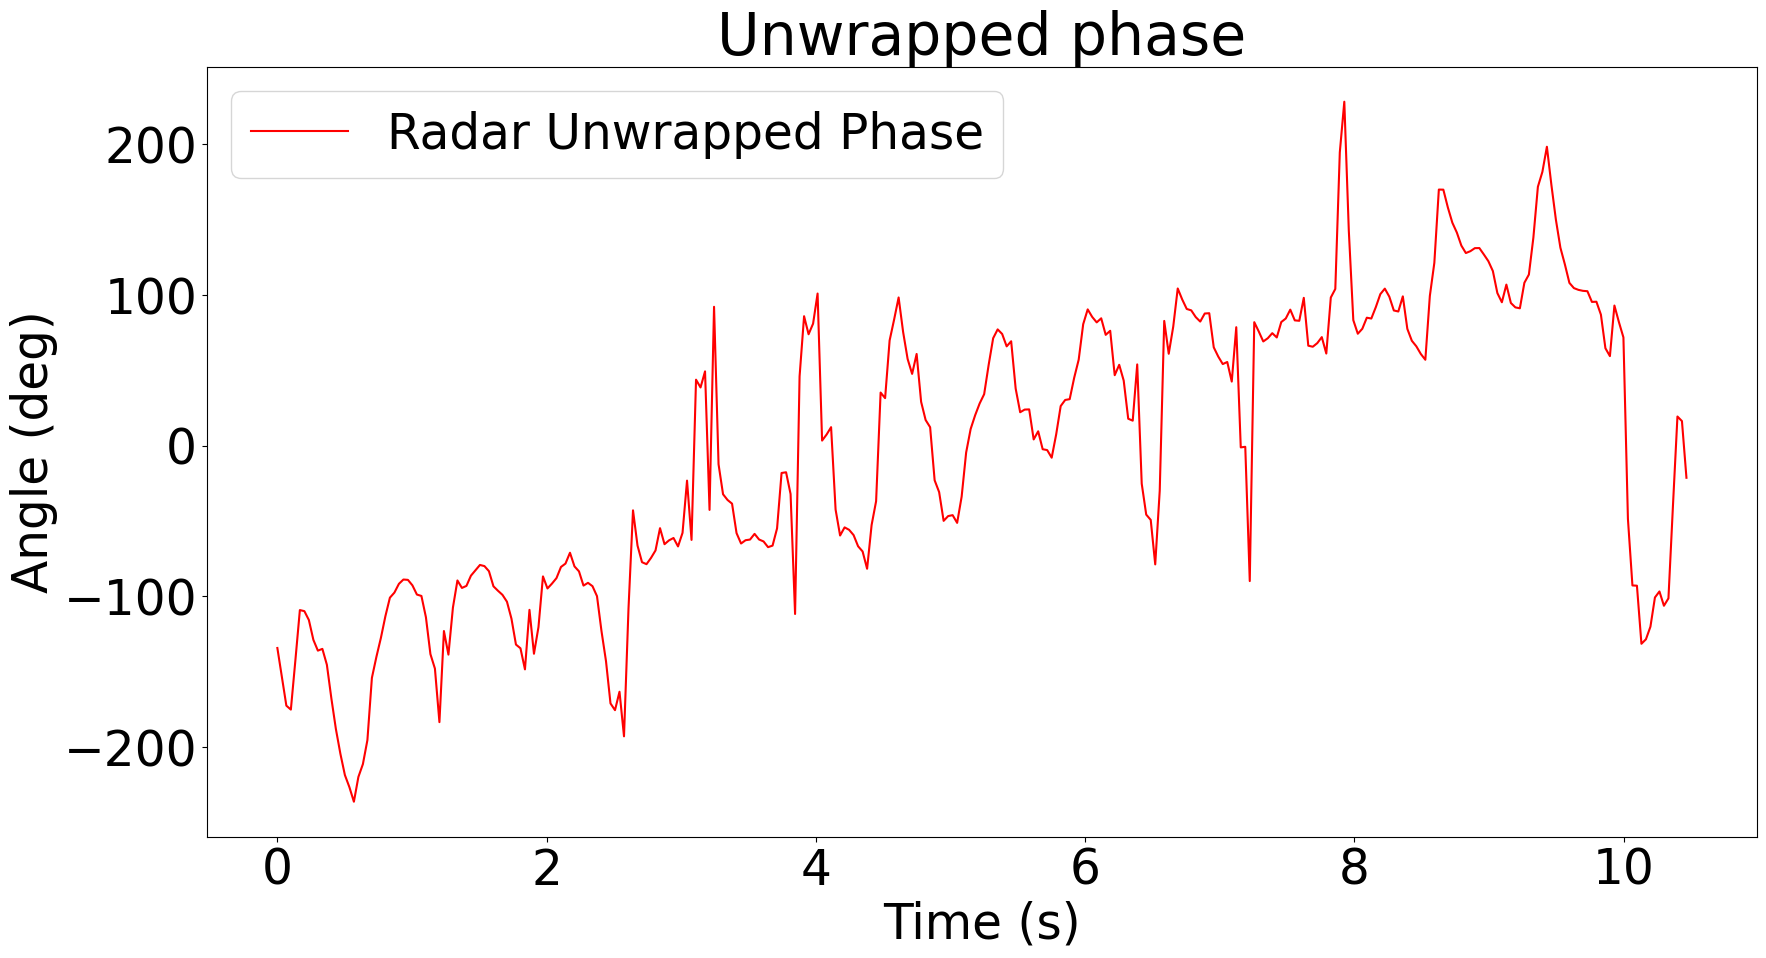

In [82]:
# Compare plot Unwrapped phase at target range bin:

%matplotlib inline
markersize=5
# for i in range(len(groundtruth)):
#     plt.plot(groundtruth[i], 0, 'o',color=(10/255, 252/255, 63/255), markersize=markersize)
# plt.plot(groundtruth[-1], 0, 'o', color=(10/255, 252/255, 63/255), markersize=markersize, label="Reference Blink")
plt.rcParams["figure.figsize"] = (20,10)

time_arr = np.linspace(0, len(unwrapped_data)/FPS, len(unwrapped_data))
plt.plot(time_arr,unwrapped_data, 'r', label='Radar Unwrapped Phase')
plt.title('Unwrapped phase')
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.legend()
plt.show()

### Signal Extraction

In [89]:
# Apply AVMD:
valid_k= 3
final_k = False
while not final_k and valid_k<20:
    # Extract Vitals: VMD decomposition
    vmd_u, vmd_u_hat, vmd_omega = vmd(unwrapped_data, K=valid_k)
    valid_signals = 0
    for i in range(len(vmd_u)):
        p = sp.sum(vmd_u[i]*vmd_u[i])/vmd_u[i].size       
        if blink_low<=fft_find_frequency(vmd_u[i])<=blink_high:
            valid_signals += 1
    if valid_signals>1:
        valid_k -= 1
        final_k = True
    else:
        valid_k += 1
        
print(f'final K: {valid_k}')

# Extract Vitals: VMD decomposition
vmd_u, vmd_u_hat, vmd_omega = vmd(unwrapped_data, K=valid_k)    
for i in range(len(vmd_u)):
    # print(i, fft_find_frequency(vmd_u[i]), p) 
    if blink_low<=fft_find_frequency(vmd_u[i])<=blink_high:  
        blink_signal = vmd_u[i]

# Normalize:
blink_signal = blink_signal/np.max(abs(blink_signal))
blink_detected = True

C:\Users\aa\AppData\Local\Temp\ipykernel_7344\1909594909.py:9: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  p = sp.sum(vmd_u[i]*vmd_u[i])/vmd_u[i].size


final K: 20


NameError: name 'blink_signal' is not defined

In [87]:

list_blink_signal=[]
for j in list_unwrapped_data:
    valid_k= 3
    final_k = False
    while not final_k and valid_k<20:
        # Extract Vitals: VMD decomposition
        vmd_u, vmd_u_hat, vmd_omega = vmd(j, K=valid_k)
        valid_signals = 0
        for i in range(len(vmd_u)):
            p = sp.sum(vmd_u[i]*vmd_u[i])/vmd_u[i].size       
            if blink_low<=fft_find_frequency(vmd_u[i])<=blink_high:
                valid_signals += 1
        if valid_signals>1:
            valid_k -= 1
            final_k = True
        else:
            valid_k += 1
            
    print(f'final K: {valid_k}')

    # Extract Vitals: VMD decomposition
    vmd_u, vmd_u_hat, vmd_omega = vmd(j, K=valid_k)    
    for i in range(len(vmd_u)):
        # print(i, fft_find_frequency(vmd_u[i]), p) 
        if blink_low<=fft_find_frequency(vmd_u[i])<=blink_high:  
            blink_signal = vmd_u[i]
            blink_signal = blink_signal/np.max(abs(blink_signal))
            list_blink_signal.append(blink_signal)

    # Normalize:
    
    blink_detected = True

C:\Users\aa\AppData\Local\Temp\ipykernel_7344\334131624.py:10: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  p = sp.sum(vmd_u[i]*vmd_u[i])/vmd_u[i].size


final K: 20
final K: 20
final K: 20


In [88]:
# Signal envelop:
%matplotlib qt
analytic_signal = hilbert(blink_signal)
amplitude_envelope = np.abs(analytic_signal)
plt.plot(time_arr, amplitude_envelope)

# Smoothing:
# smoothed_signal = savgol_filter(amplitude_envelope, window_length=3*FPS+1, polyorder=3)
# smoothed_signal = savgol_filter(smoothed_signal, window_length=3*FPS+1, polyorder=3)
# plt.plot(time_arr, smoothed_signal)

markersize=10
for i in range(len(groundtruth)-1):
    plt.plot(groundtruth[i], 0, 'o',color=(106/255, 90/255, 205/255), markersize=markersize)
plt.plot(groundtruth[-1], 0, 'o', color=(106/255, 90/255, 205/255), markersize=markersize, label="Reference Blink")

NameError: name 'blink_signal' is not defined

In [86]:
%matplotlib qt
signal_sum=list_blink_signal[-1]    
analytic_signal = hilbert(signal_sum)
amplitude_envelope = np.abs(analytic_signal)
plt.plot(time_arr, amplitude_envelope)
plt.legend(signal_sum)

# Smoothing:
# smoothed_signal = savgol_filter(amplitude_envelope, window_length=3*FPS+1, polyorder=3)
# smoothed_signal = savgol_filter(smoothed_signal, window_length=3*FPS+1, polyorder=3)
# plt.plot(time_arr, smoothed_signal)
# plt.legend(signal_sum)

markersize=5
for i in range(len(groundtruth)):
    plt.plot(groundtruth[i], 0, 'o',color=(106/255, 90/255, 205/255), markersize=markersize)
    plt.axvline(groundtruth[i],color='g',linewidth=2,linestyle=':')
# plt.plot(groundtruth[-1], 0, 'o', color=(106/255, 90/255, 205/255), markersize=markersize, label="Reference Blink")

IndexError: list index out of range

In [26]:
%matplotlib qt
for i in list_blink_signal[0:-1]:    
    analytic_signal = hilbert(i)
    amplitude_envelope = np.abs(analytic_signal)
    plt.plot(time_arr, amplitude_envelope)
    # plt.legend(i)

# Smoothing:
    # smoothed_signal = savgol_filter(amplitude_envelope, window_length=3*FPS+1, polyorder=3)
    # smoothed_signal = savgol_filter(smoothed_signal, window_length=3*FPS+1, polyorder=3)
    # plt.plot(time_arr, smoothed_signal)
    plt.legend(i)

markersize=5
for i in range(len(groundtruth)):
    plt.plot(groundtruth[i], 0, 'o',color=(106/255, 90/255, 205/255), markersize=markersize)
    plt.axvline(groundtruth[i],color='g',linewidth=2,linestyle=':')
# plt.plot(groundtruth[-1], 0, 'o', color=(106/255, 90/255, 205/255), markersize=markersize, label="Reference Blink")


### Blink Detection

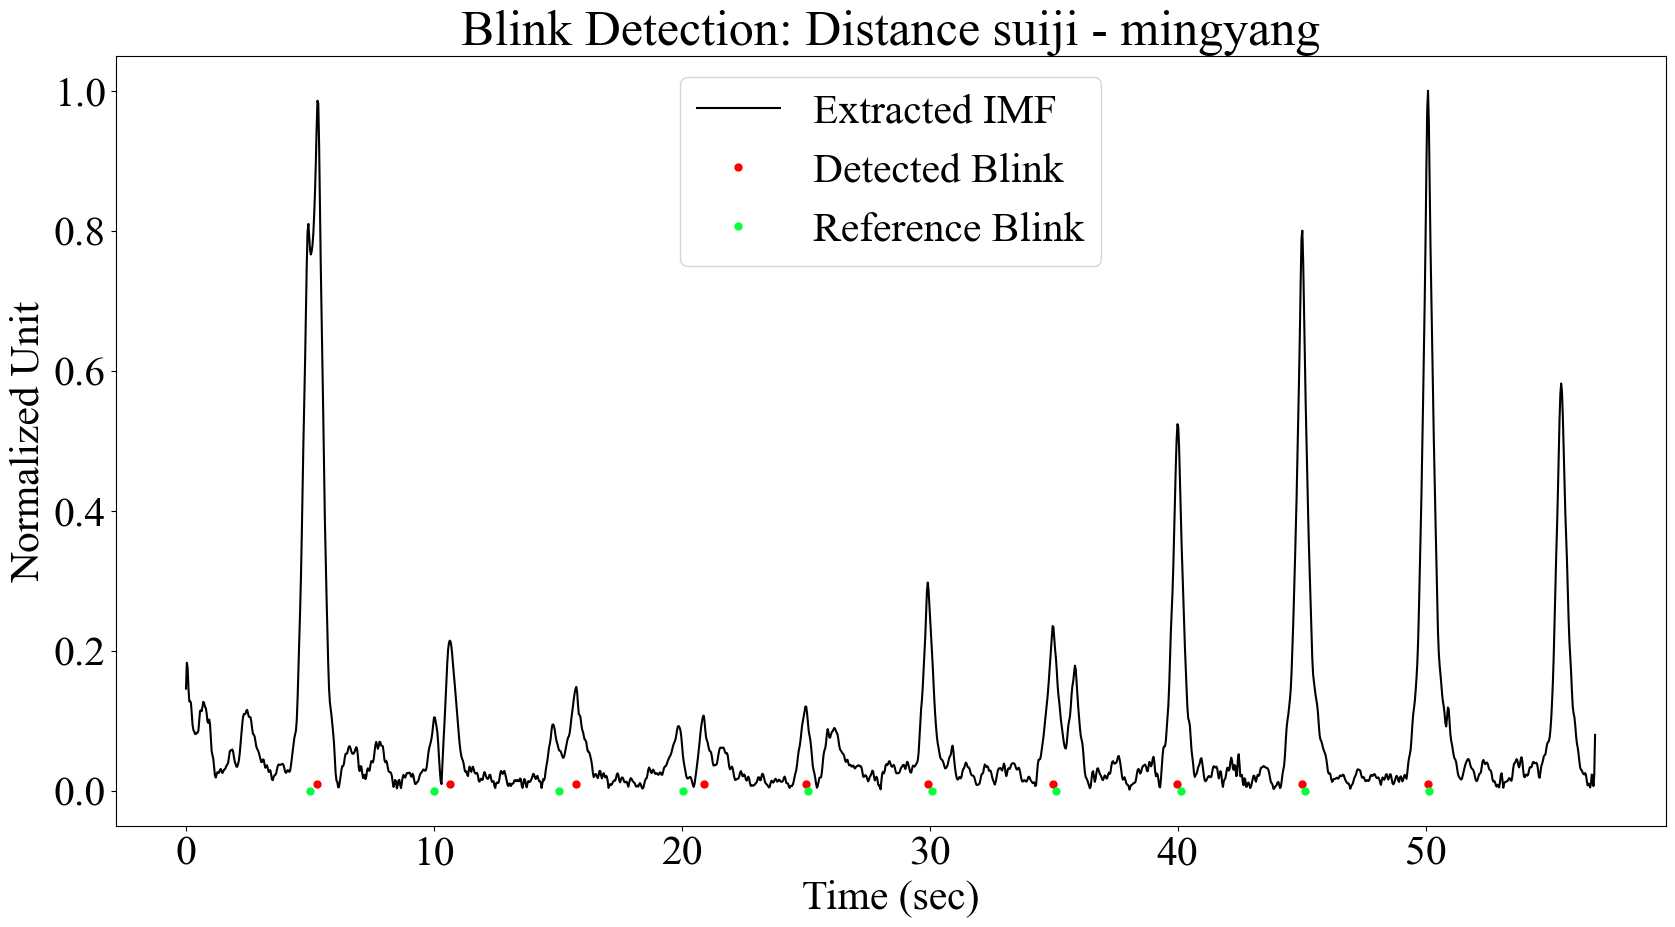

The number of detected peaks is: 10


In [ ]:

if blink_detected:
    %matplotlib inline
    average_blink = 2.9 # in seconds
    distance = FPS*average_blink
    height = .1
    width= 1
    prominence = .08
    # peaks,_ = find_peaks(smoothed_signal, distance=distance, )#, width=width)

    # # Remove first and last peak:
    # head, tail = peaks[0], peaks[-1]
    # format_blink_signal = np.zeros(len(smoothed_signal))
    format_blink_signal =amplitude_envelope
    # format_blink_signal = smoothed_signal   # Other subjects
    # format_blink_signal[head+FPS:tail-FPS] = blink_signal[head+FPS:tail-FPS]  # control PC by subject

    # Normalize Signal:
    format_blink_signal = format_blink_signal/np.max(np.abs(format_blink_signal))

    # Recheck Peaks:
    dummy_signal = np.copy(format_blink_signal)
    dummy_signal[:2*FPS] = 0
    dummy_signal[-2*FPS:] = 0
    peaks,_ = find_peaks(dummy_signal, distance=distance, prominence=prominence)#, height=height, prominence=prominence, width=width)
    # Plot results:
    plt.rcParams.update({'font.size': 30})
    plt.rcParams["font.family"] = "times new roman"
    import matplotlib.colors as mcolors

    markersize=5
    # plt.plot(time_arr[:len(format_blink_signal)], format_blink_signal, color=(0/255, 0/255, 0/255), label = "Extracted IMF")
    plt.plot(time_arr, format_blink_signal[:len(time_arr)], color=(0/255, 0/255, 0/255), label = "Extracted IMF")
    # for i in range(len(peaks)-1):
    #     plt.plot(time_arr[peaks[i]], format_blink_signal[peaks[i]], 'ro', markersize=markersize)
    # plt.plot(time_arr[peaks[-1]], format_blink_signal[peaks[-1]], 'ro', markersize=markersize, label="Detected Blink")
    for i in range(len(peaks)-1):
        plt.plot(time_arr[peaks[i]], 0.01, 'ro', markersize=markersize)
    plt.plot(time_arr[peaks[-1]], 0.01, 'ro', markersize=markersize, label="Detected Blink")

    for i in range(len(groundtruth)-1):
        plt.plot(groundtruth[i], 0, 'o',color=(10/255, 252/255, 63/255), markersize=markersize)
    plt.plot(groundtruth[-1], 0, 'o', color=(10/255, 252/255, 63/255), markersize=markersize, label="Reference Blink")

    plt.xlabel("Time (sec)")
    plt.ylabel("Normalized Unit")
    plt.title(f"Blink Detection: {experiment_title}")
    plt.legend(loc='best')
    plt.show()

    print(f"The number of detected peaks is: {len(peaks)}")

In [85]:
%matplotlib qt
target_range = 8
STFT_matrix = []
clutter_removal_enabled = True
for i in range(matnp.shape[0]):
    radar_cube = matnp[i, :, :, :]
    fft2d_log_abs, aoa_input = doppler_processing(radar_cube,
                                                  num_tx_antennas=3,
                                                  clutter_removal_enabled=clutter_removal_enabled,
                                                  interleaved=True,
                                                  window_type_2d=None,
                                                  accumulate=True)
    upper = fft2d_log_abs[:, 1:16].T
    lower = fft2d_log_abs[:, 16:32].T
    doppler_out = np.vstack((lower, upper))
    STFT_matrix.append(doppler_out[:, target_range])
print(len(doppler_out))
frame = len(STFT_matrix)
STFT_plot = np.vstack((STFT_matrix)).T
print(STFT_plot.shape)

# plot STFT
plt.imshow(STFT_plot[14:18,0:frame], extent=[0, frame/30-5, 1.8, -1.92],aspect='auto',cmap='turbo')
plt.xlabel("time (s)")
plt.ylabel("Velocity (m/s)")

NameError: name 'doppler_processing' is not defined